In [1]:
import argparse
import scipy
from scipy import ndimage
import cv2
import numpy as np
import sys
from collections import OrderedDict
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import torch.nn.functional as F
from torch.utils import data, model_zoo
import utils.palette as palette

from model.deeplabv2 import Res_Deeplab
from data import get_data_path, get_loader
from torchvision import transforms
from utils.helpers import colorize_mask, get_concat_h, get_concat_v

from PIL import Image
import scipy.misc
from utils.loss import CrossEntropy2d

IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)


MODEL = 'deeplabv2' # deeeplabv2, deeplabv3p


In [2]:
model_path = "/home/erik/phd/code/dacs_fork/saved/DeepLabv2/11-21_16-10-UDA"
model_path = os.path.join(model_path, "checkpoint-iter10000.pth")

#model = torch.nn.DataParallel(Res_Deeplab(num_classes=num_classes), device_ids=args.gpu)
model = Res_Deeplab(num_classes=19)

checkpoint = torch.load(model_path)
try:
    model.load_state_dict(checkpoint['model'])
except:
    model = torch.nn.DataParallel(model)
    model.load_state_dict(checkpoint['model'])

model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1

In [3]:
from model.deeplabv2 import Extractor

extractor = Extractor(model.conv1, model.bn1, model.relu, model.maxpool,
    model.layer1, model.layer2, model.layer3, model.layer4)


In [4]:
from utils_uda.SSHead import linear_on_layer3_square_img

head = linear_on_layer3_square_img(5, 0, int(128 / 128)).cuda()


model_path = "/home/erik/phd/code/dacs_fork/saved/DeepLabv2/11-21_16-10-UDA"
model_path = os.path.join(model_path, "head_final")

head.load_state_dict(torch.load(model_path))



<All keys matched successfully>

# Load data

In [5]:
from data.gta5_dataset import SsGTA5
from data.cityscapes_loader import SsCityscapes
import numpy as np
from data import get_data_path
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
%matplotlib inline
class DeNormalize(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, tensor):
        IMG_MEAN = torch.from_numpy(self.mean.copy())
        IMG_MEAN, _ = torch.broadcast_tensors(IMG_MEAN.unsqueeze(1).unsqueeze(2), tensor)
        tensor = tensor+IMG_MEAN
        tensor = (tensor/255).float()
        tensor = torch.flip(tensor,(0,))
        return tensor

IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)

restore_transform = transforms.Compose([
DeNormalize(IMG_MEAN),
transforms.ToPILImage()])

In [6]:
IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)
data_path = get_data_path('gta')

source_ds = SsGTA5(
    root=data_path,
    list_path='./data/gta5_list/train.txt',
    augmentations=None,
    img_size=(1280,720),
    mean=IMG_MEAN,
    crop_size=128
    )

In [7]:
def make_preds_with_attenuation(start, stop, plot):
    
    correct_preds = []
    incorrect_preds = []

    all_preds = []
    all_uncertainties = {}
    all_raw_preds = {}

    all_images = {}

    black_images = []

    with torch.no_grad():
        for i in range(start, stop):
            ori_img_ ,label = source_ds[i]
            img = np.reshape(ori_img_, (1, *ori_img_.shape))
            img = torch.tensor(img).cuda()
            features = extractor(img)
            ss_task_pred = head(features)
            # loss = ss_tasks[0].criterion(ss_task_pred, torch.tensor([label]).cuda())

            pred_label = torch.argmax(ss_task_pred[:, 0:4], axis=1).detach().cpu().item()
            pred_log_uncertainty = ss_task_pred[:, -1].detach().cpu().item()

            all_preds.append(pred_label)
            all_uncertainties[i] = np.exp(pred_log_uncertainty)
            all_raw_preds[i] = torch.nn.Softmax(dim=1)(ss_task_pred[:, 0:4])
            
            if pred_label == label:
                correct_preds.append(i)
            else:
                incorrect_preds.append(i)

            if plot:
                temp = list(all_raw_preds[i].detach().cpu().numpy()[0])
                temp = [float(f"{x:.2f}") for x in temp]
                print(temp)
                print(f"pred_label: {pred_label}")
                print(f"label: {label}")
                # loss = loss.detach().cpu().numpy()
                # print(f"loss: {loss[0]:.2f}")

            ori_img_ = restore_transform(torch.tensor(ori_img_))

            # if np.sum(ori_img_  != ori_img_[0,0]) == 16384:
            #     black_images.append(i)
            all_images[i] = ori_img_
        
            if plot:
                plt.imshow(ori_img_.transpose((1,2,0)).astype(np.uint8))
                plt.title("uncertainty=" + str(round(np.exp(pred_log_uncertainty), 2)) + ", log_uncertainty= " + str(round(pred_log_uncertainty, 2)))
                plt.show()

    print("Number of correct preds:")
    print(len(correct_preds))

    print("Number of incorrect preds:")
    print(len(incorrect_preds))

    return correct_preds, incorrect_preds, all_preds, all_uncertainties, all_raw_preds, all_images, black_images

In [16]:
start, stop = 5000,5030
plot = False
correct_preds, incorrect_preds, all_preds, uncertainty, all_raw_preds, all_images, black_images = make_preds_with_attenuation(start, stop, plot)


/home/erik/anaconda3/envs/dacs3/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Number of correct preds:
10
Number of incorrect preds:
20


In [19]:
correct_preds

[5001, 5002, 5003, 5005, 5006, 5007, 5010, 5021, 5025, 5029]

In [22]:
np.mean([uncertainty[x] for x in correct_preds])

12.187435090622067

In [23]:
np.mean([uncertainty[x] for x in incorrect_preds])

24.412656939132546

In [17]:

indices =  sorted(zip(list(uncertainty.keys()), list(uncertainty.values())), key=lambda x: abs(x[1]))

indices = [x for x in indices if x[0] not in black_images]

correct


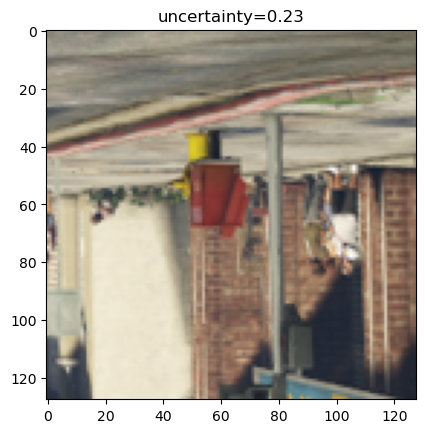

correct


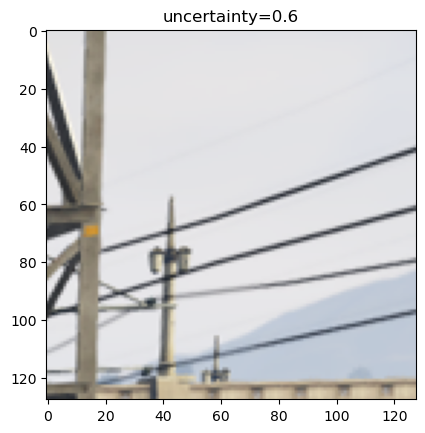

correct


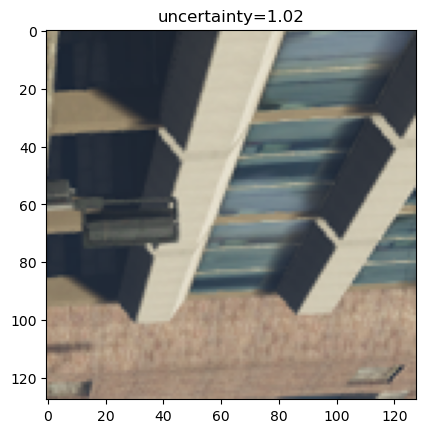

incorrect


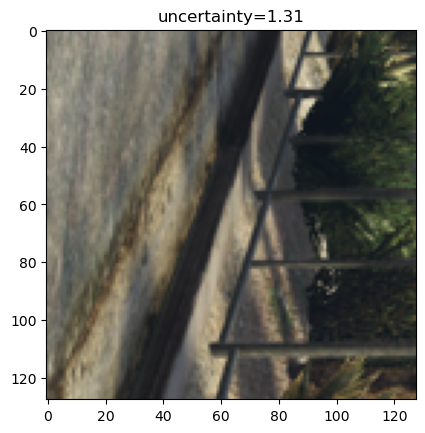

incorrect


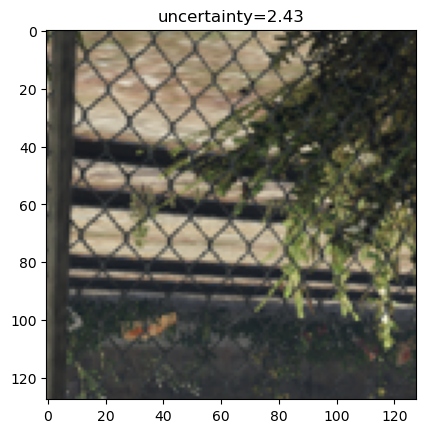

correct


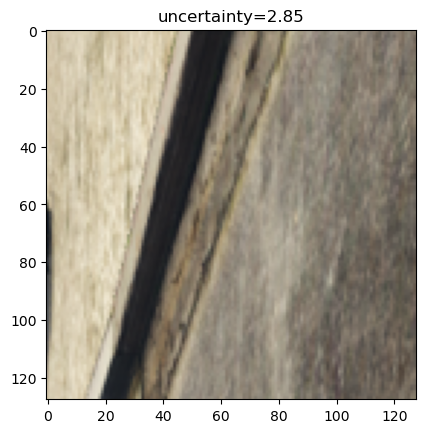

correct


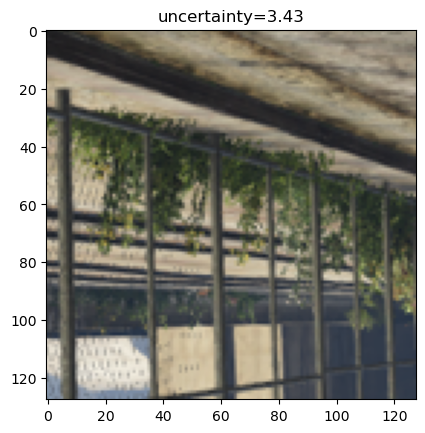

incorrect


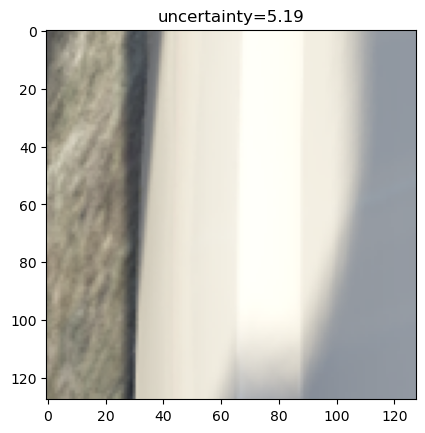

incorrect


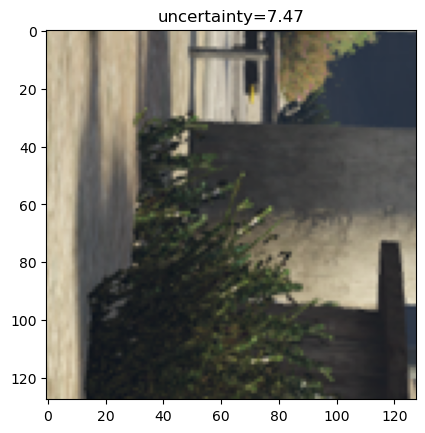

correct


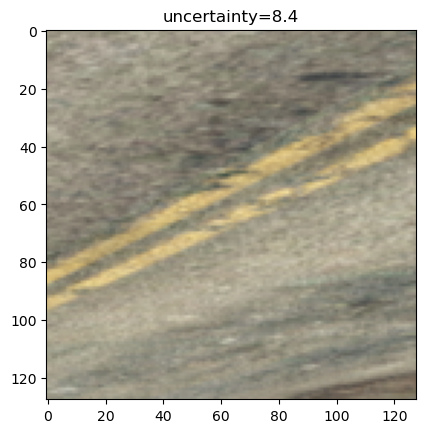

incorrect


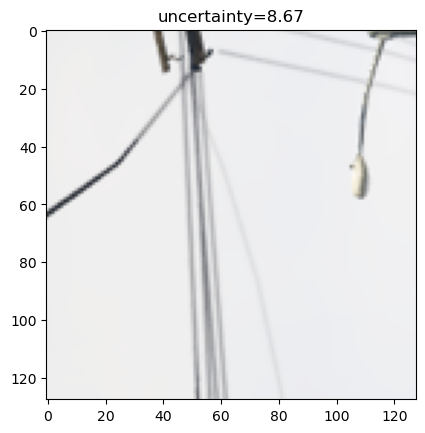

incorrect


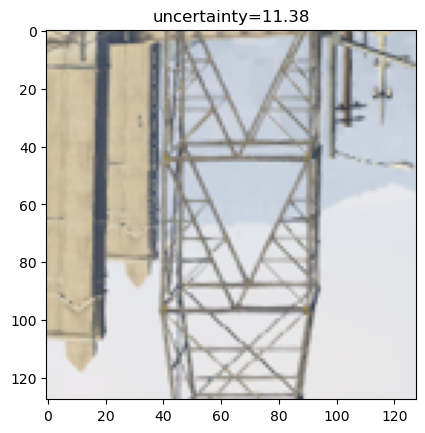

correct


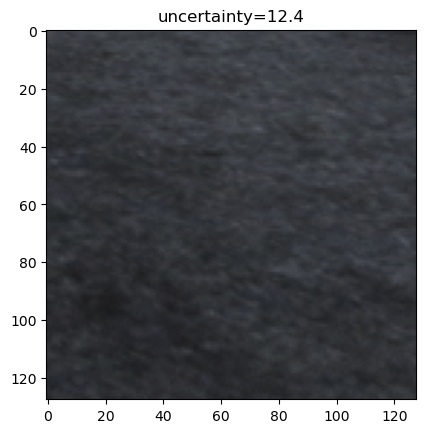

incorrect


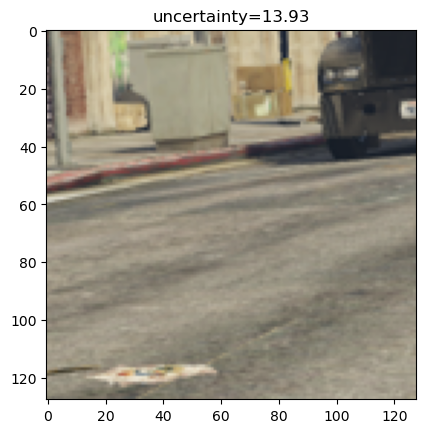

incorrect


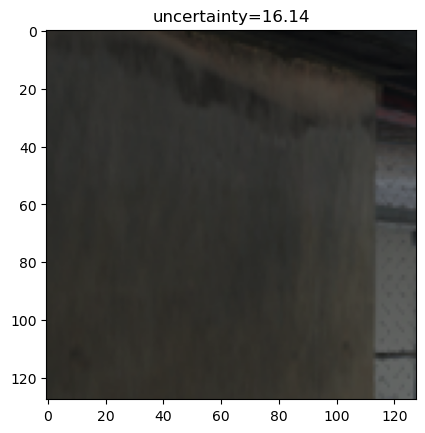

correct


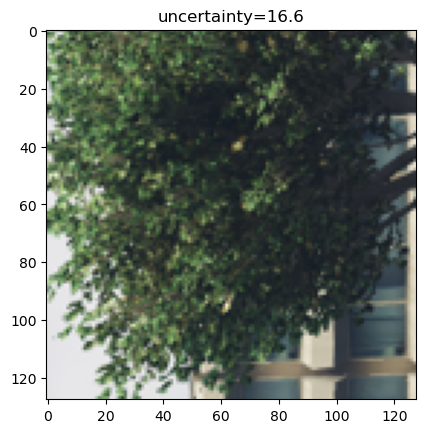

incorrect


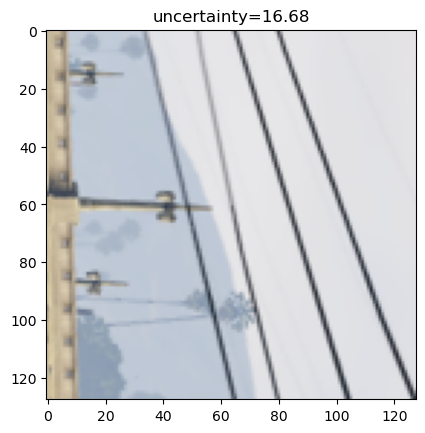

incorrect


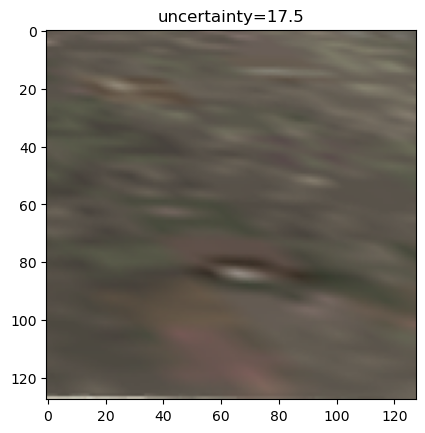

incorrect


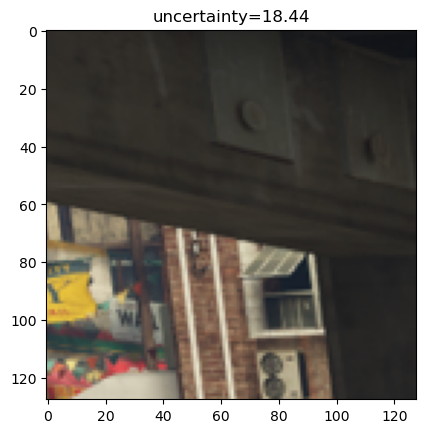

incorrect


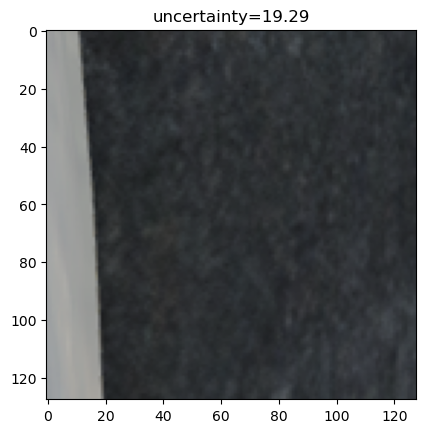

correct


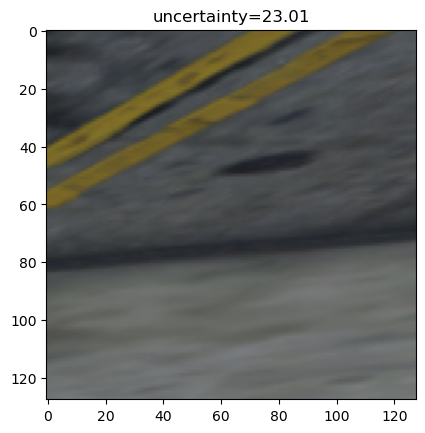

incorrect


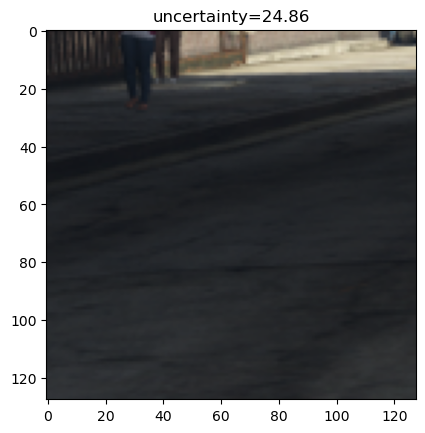

incorrect


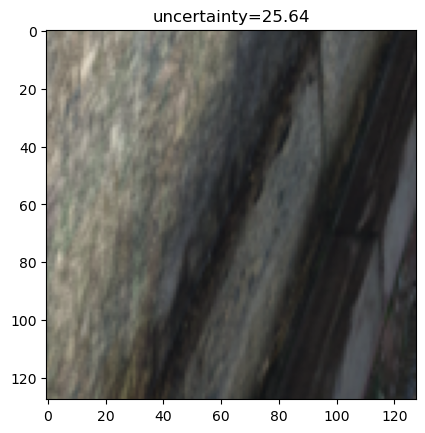

incorrect


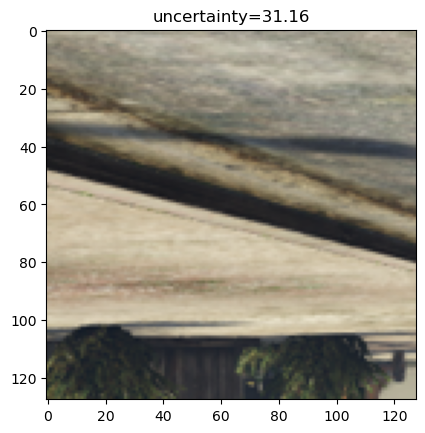

incorrect


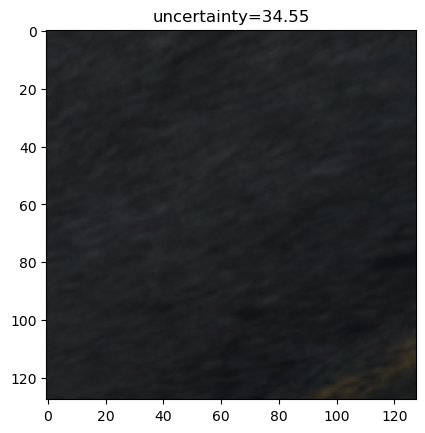

incorrect


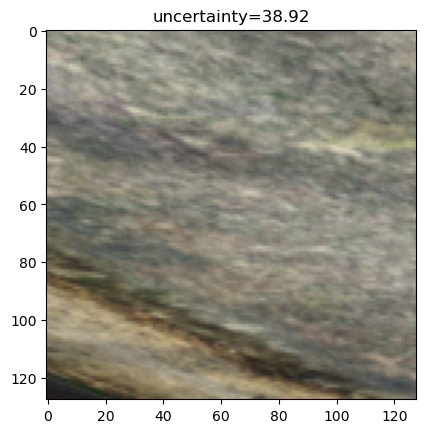

incorrect


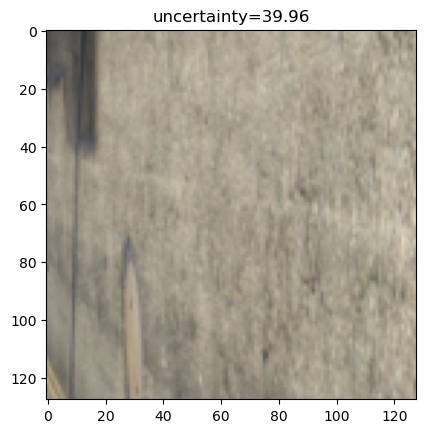

incorrect


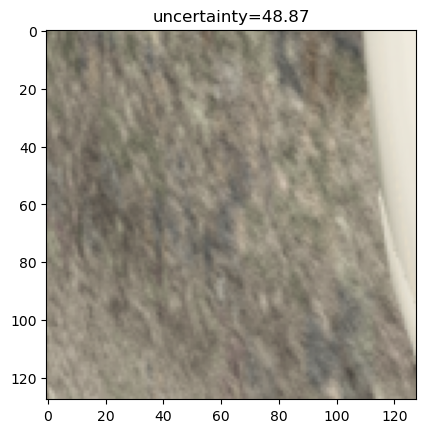

correct


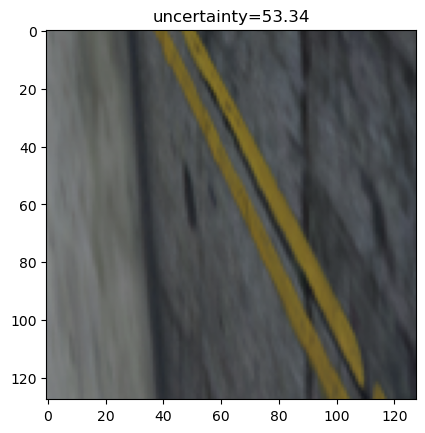

incorrect


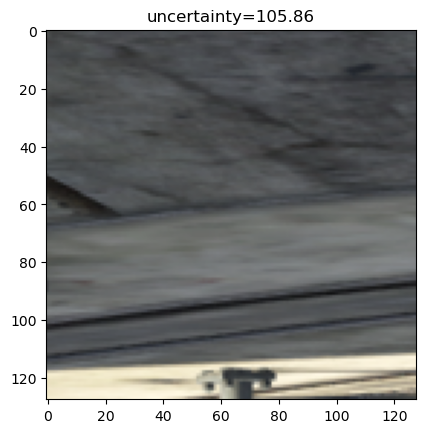

In [25]:
for i, uncert in indices:
    if i in correct_preds:
        print(f"correct")
    else:
        print("incorrect")
    ori_img_ = np.array(all_images[i])
    plt.imshow(ori_img_.astype(np.uint8))
    if uncertainty is not None:
        plt.title("uncertainty=" + str(round(uncert, 2)))
    plt.show()